# PROYECTO 16

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

No se esta utilizando BERT.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Exploración de datos

In [5]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
4288,tt0437856,tvMovie,Behind the Camera: The Unauthorized Story of M...,Behind the Camera: The Unauthorized Story of M...,2005,\N,85,0,"Comedy,Drama",6.9,407,"who's responsible for these ""behind the scenes...",1,neg,0,test,806
45106,tt0259711,movie,Vanilla Sky,Vanilla Sky,2001,\N,136,0,"Fantasy,Mystery,Romance",6.9,242850,"As the one-line summary says, two movies have ...",10,pos,1,train,7468
23975,tt0086006,movie,Never Say Never Again,Never Say Never Again,1983,\N,134,0,"Action,Adventure,Thriller",6.2,59411,This is more than just an adaptation of Bond: ...,4,neg,0,test,2287
17334,tt0455538,movie,How to Lose Friends & Alienate People,How to Lose Friends & Alienate People,2008,\N,110,0,"Biography,Comedy,Drama",6.4,67071,'How to Lose Friends and Alienate People' is a...,8,pos,1,train,9733
10692,tt0101764,movie,Double Impact,Double Impact,1991,\N,110,0,"Action,Crime",5.6,37011,Twin brothers separated at birth (Due to the d...,2,neg,0,train,6839


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

En esta primer revisión encontramos solo 2 datos ausentes, por lo que serán eliminados. 
Sin embargo, hay 2 columnas que se presentan Dtype 'object' y deberian ser numero dado la naturaleza del nombre de la columna 'end_year' y 'runtime_minutes', vamos a analizar el contenido de estas columnas y convertirlas al Dtype correcto.

In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
#Validación de datos ausentes
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
#Validación de duplicados
df_reviews.duplicated().sum()

0

In [10]:
## Eliminar ausentes

df_reviews = df_reviews.dropna()

print(df_reviews.isnull().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [11]:
## Conversión de columna 'end_year' a número entero respetando los nulos.

df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

In [12]:
##Validación de ausentes posterior a la conversión a tipo númerico.
df_reviews['end_year'].isna().sum()

45050

In [13]:
# Validación de datos no númericos en la columna 'runtime_minutes'.
(~df_reviews['runtime_minutes'].str.isnumeric()).sum()

486

In [14]:
#Conversión de columna 'runtime_minutes' a tipo numerico.
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')

In [15]:
df_reviews.isnull().sum()

tconst                 0
title_type             0
primary_title          0
original_title         0
start_year             0
end_year           45050
runtime_minutes      486
is_adult               0
genres                 0
average_rating         0
votes                  0
review                 0
rating                 0
sp                     0
pos                    0
ds_part                0
idx                    0
dtype: int64

Con base al analisis de datos ausentes realizados a las columnas 'end_year' y 'runtime_minutes', decido que la columna 'year_end' será eliminada ya que no aportara ninguna información al modelo debido a que más del 80% de los datos estan ausentes. En el caso de 'runtime_minutes' analizaremos los datos con .describe para decidir como imputar los valores ausentes.

In [16]:
#Eliminar columna 'end_year'

df_reviews = df_reviews.drop('end_year', axis=1)

In [17]:
df_reviews['runtime_minutes'].describe()

count    46843.000000
mean        98.759729
std         38.322569
min          1.000000
25%         87.000000
50%         95.000000
75%        109.000000
max       1140.000000
Name: runtime_minutes, dtype: float64

La media con 98.75 no es muy diferente a la mediana 95.00, sin embargo, tenemos un valor muy extremo comparado al 75% con valor de 109.00, lo que quiere decir que hay valores extremos y un sesgo a la derecha. 
Decido imputar los datos con la mediana ya que la media se ve ligeramente afectada por el outliner.

In [18]:
df_reviews['runtime_minutes'].fillna(df_reviews['runtime_minutes'].median(), inplace=True)

In [19]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   runtime_minutes  47329 non-null  float64
 6   is_adult         47329 non-null  int64  
 7   genres           47329 non-null  object 
 8   average_rating   47329 non-null  float64
 9   votes            47329 non-null  Int64  
 10  review           47329 non-null  object 
 11  rating           47329 non-null  int64  
 12  sp               47329 non-null  object 
 13  pos              47329 non-null  int64  
 14  ds_part          47329 non-null  object 
 15  idx              47329 non-null  int64  
dtypes: Int64(1), float64(2), int64(5), object(8)
memory usage:

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

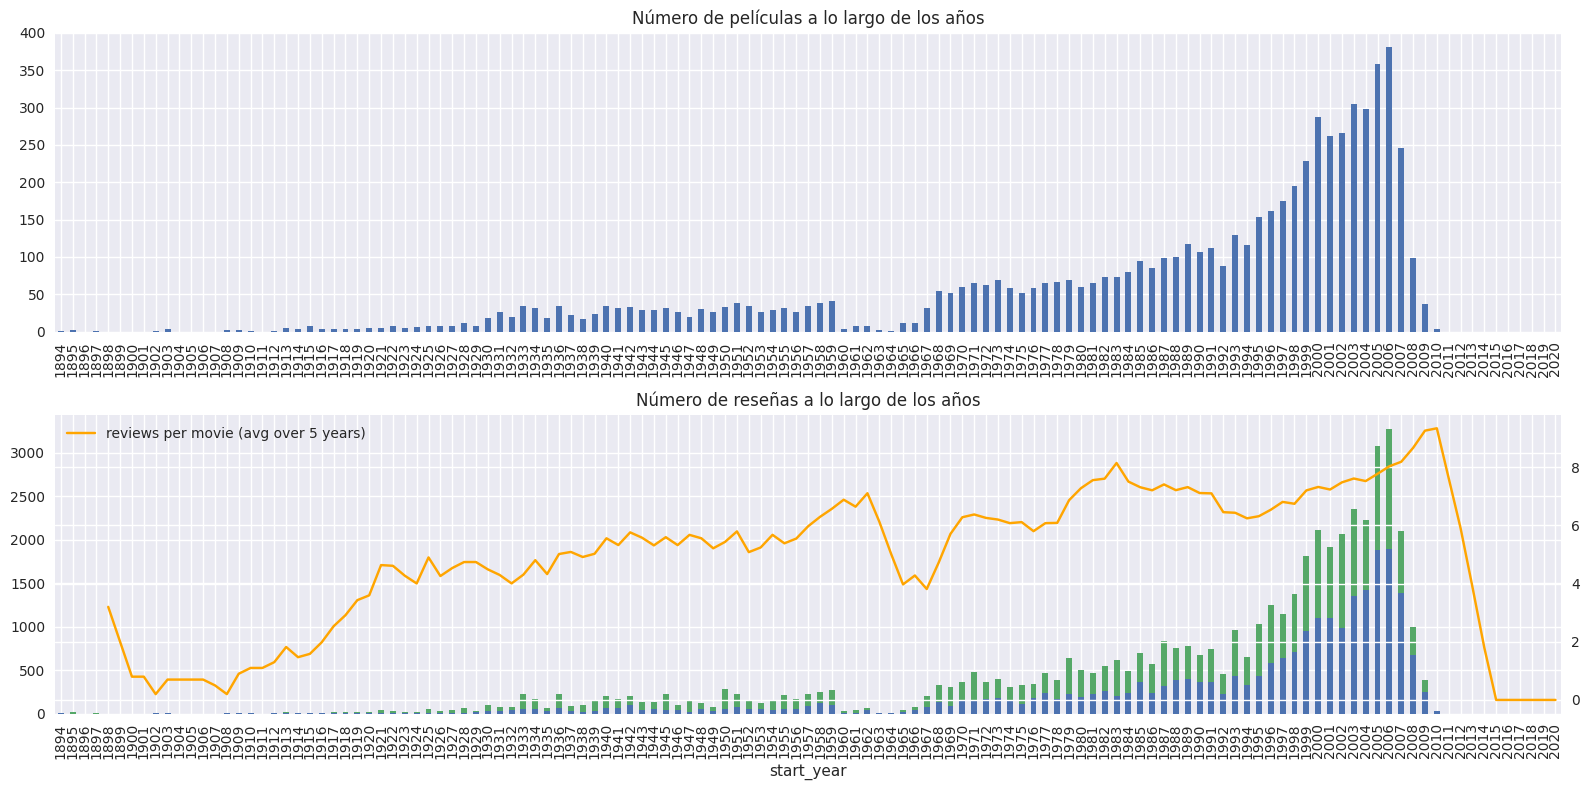

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

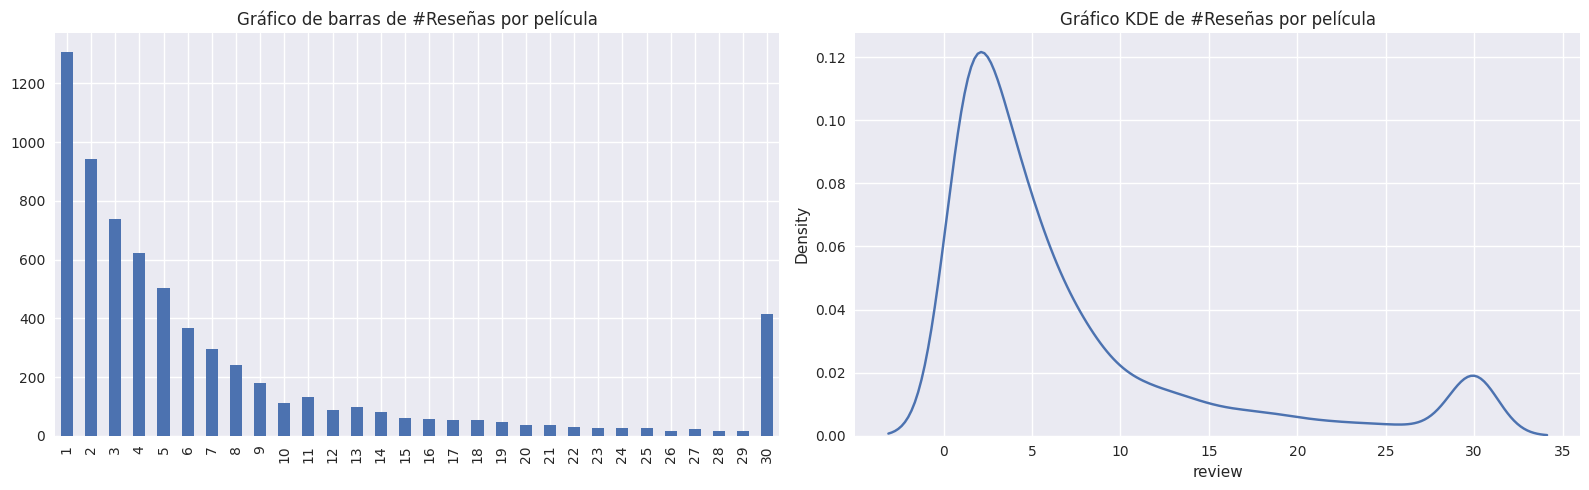

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

### Analisis de Desequilibrio de Clases

In [22]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

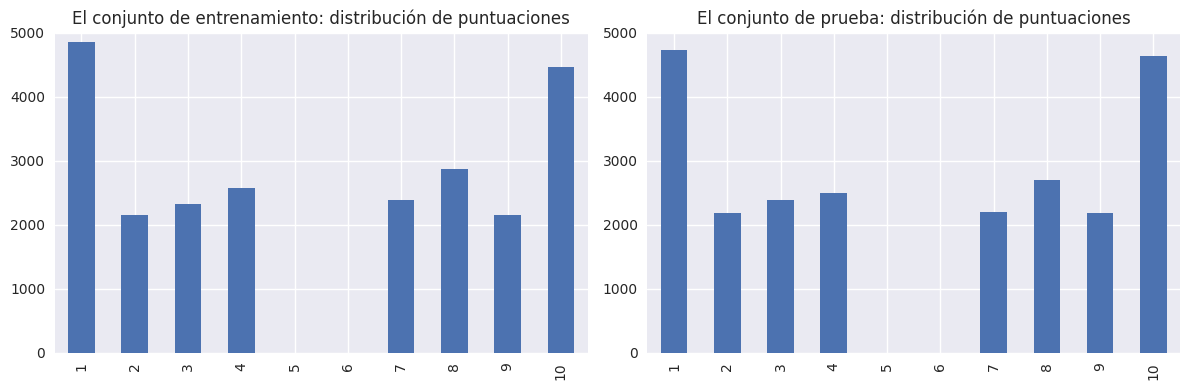

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

No se observa un desequilibrio significativo que requiera técnicas de balanceo como sobremuestreo (oversampling) o submuestreo (undersampling).

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


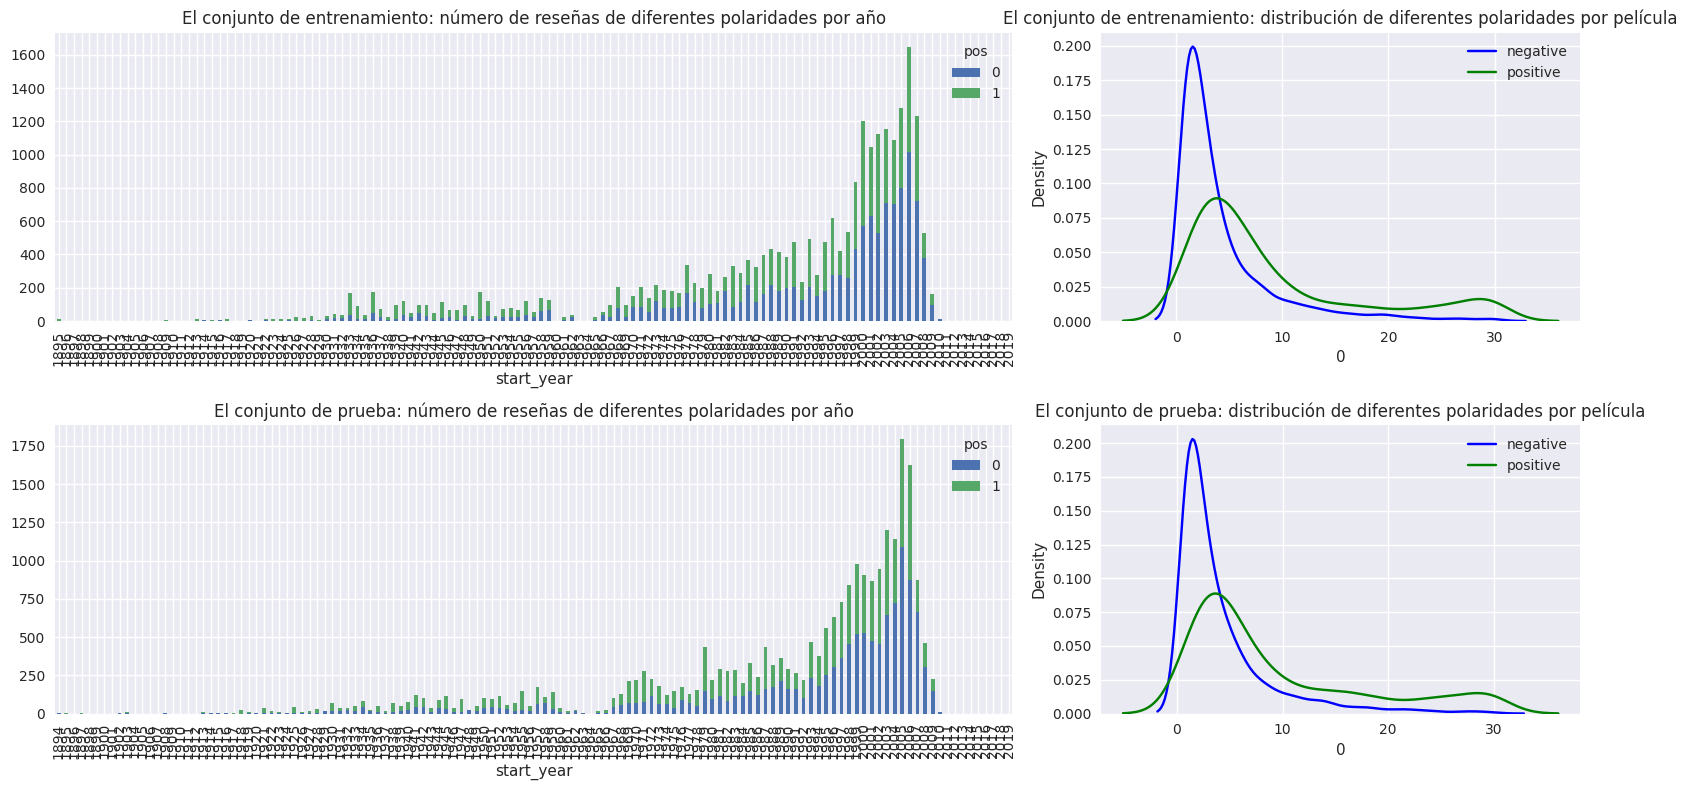

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Podemos observar que ambas particiones (entrenamiento y prueba) la mayoria de las reseñas de son de peliculas recientes (1990 - 2009), la proporcion entre reseñas positivas y negativas tienen una distribución normal.

También observamos que en la distribución de polaridades por película, la mayoria tiene de 1 a 2 reseñas mayormente negativa, en el resto tienen una distribución muy similar.


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [25]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

Creamos una función para limpiar el texto para que los modelos funcione de manera correcta. 
Se convertira el texto a minusculas y quitamos todo aquello que sean signos de puntuación, digitos y demás que pueda interferir en nuestro entrenamiento.

In [26]:
def clear_text(text):
    clean_text = text.lower()
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = " ".join(clean_text.split())
    return clean_text 

In [27]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [28]:
df_reviews[['review', 'review_norm']].head(5)

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


Como se observa hemos creados una columna que nos arroja el texto de forma que los modelos puedan trabajar con el. 

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23533, 17)


## Trabajar con modelos

### Modelo 0 - Constante

In [30]:
from sklearn.dummy import DummyClassifier

Para que funcione DummyClassifier necesitamos proporcionar caracteristicas, en el siguiente paso crearemos un array con zeros ya que no aprendará el modelo nada en este momento.

In [31]:
train_features_0 = np.zeros((df_reviews_train.shape[0], 1))
test_features_0 = np.zeros((df_reviews_test.shape[0], 1))

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


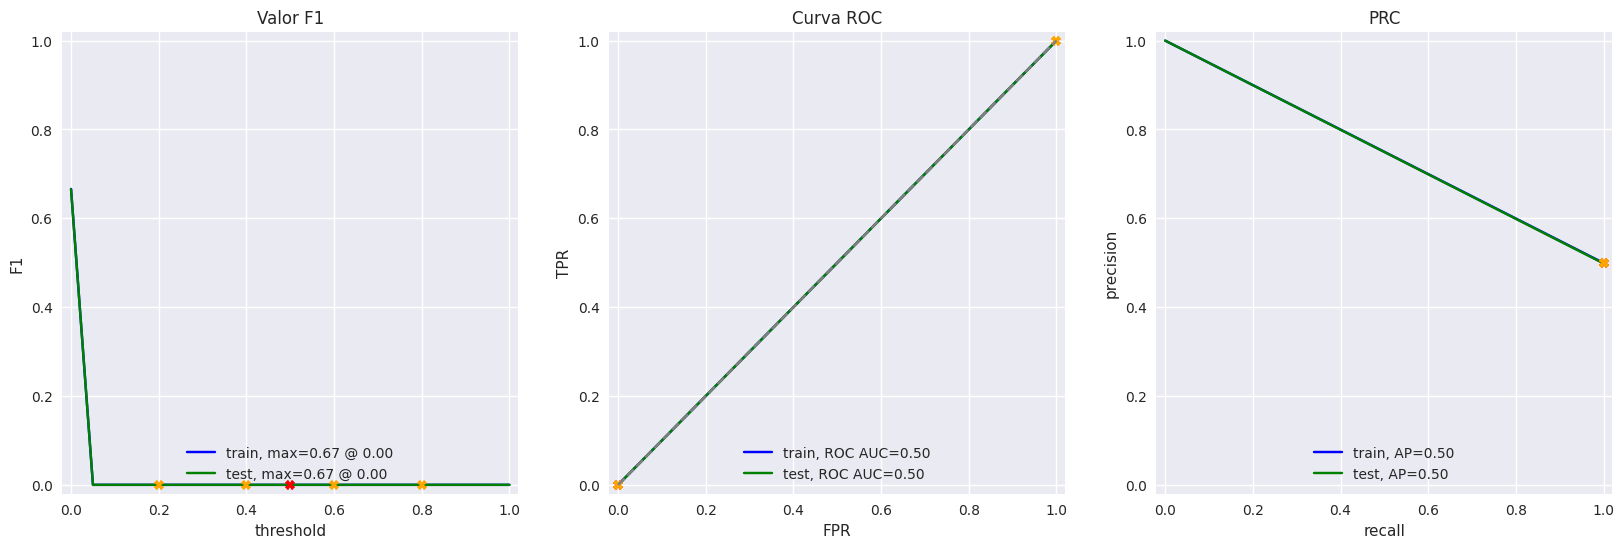

In [32]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features_0,train_target)

dummy_clf.predict(test_features_0)
dummy_clf.score(test_features_0, test_target)

evaluate_model(dummy_clf, train_features_0, train_target, test_features_0, test_target)

En el Modelo 0 - Constante, se utilizó DummyClassifier de scikit-learn, un clasificador que realiza predicciones sin considerar las características de entrada. Su propósito principal es servir como una línea base para comparar el rendimiento de modelos más complejos.

Para entrenar este modelo, se creó un arreglo de ceros como características (X) tanto para entrenamiento como para prueba, ya que el modelo no requiere información real.

Como era de esperarse, el modelo arrojó un valor F1 de 0.0, ya que solo predice la clase más frecuente y nunca acierta la minoritaria. Las métricas ROC AUC y APS fueron de 0.50, lo cual refleja un desempeño equivalente al azar. Estos resultados establecen el mínimo de referencia que cualquier modelo entrenado posteriormente debe superar.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [33]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [35]:
# Obtenemos caracteristicas para el modelo de regresión logistica a partir de TfidfVectorizer.
train_corpus = df_reviews_train['review_norm']
stop_words = set(stopwords.words('english'))

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
tf_idf = tfidf_vectorizer_1.fit_transform(train_corpus)

train_features_1 = tf_idf #extraemos caracteristicas para entrenamiento.

test_corpus = df_reviews_test['review_norm'] #Extrae reseñas lemantizadas para prueba
test_features_1 = tfidf_vectorizer_1.transform(test_corpus) #transforma el corpus de prueba

In [36]:
#Entrenamiento de modelo
model_1 = LogisticRegression() 
model_1.fit(train_features_1,train_target) #Inicia modelo de regresión y ajuste.
pred_test = model_1.predict(test_features_1) #Obtiene predicciones de la parte de prueba.

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


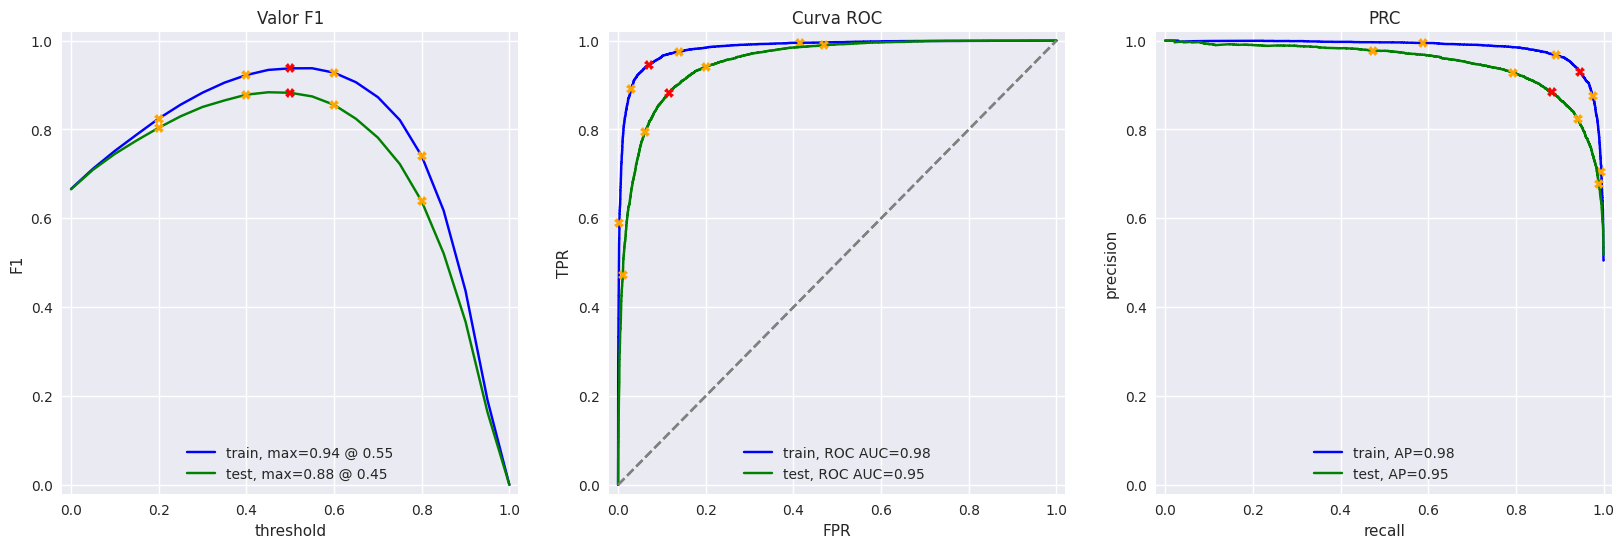

In [37]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

En el Modelo 1 se utilizaron valores TF-IDF como características, un enfoque clásico de procesamiento de texto. Se eliminaron las stopwords en inglés utilizando NLTK, y se entrenó un modelo de regresión logística.

El modelo obtuvo un desempeño significativamente superior al DummyClassifier. En el conjunto de prueba alcanzó un F1 de 0.88, mientras que en entrenamiento logró F1 = 0.94. Las métricas adicionales —ROC AUC = 0.95 y APS = 0.95— confirman la solidez del modelo y su capacidad de generalización.

### Modelo 3 - spaCy, TF-IDF y LR

In [38]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [39]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [40]:
df_reviews_train['review_spacy'] = df_reviews_train['review'].progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

In [41]:
df_reviews_test['review_spacy'] = df_reviews_test['review'].progress_apply(text_preprocessing_3)

  0%|          | 0/23533 [00:00<?, ?it/s]

In [42]:
df_reviews_train['review_spacy'].head()

0    the pakage imply that Warren Beatty and Goldie...
1    how the hell do they get this make ? ! present...
7    this true story of Carlson 's Raiders be more ...
8    should have be title ' Balderdash ! ' little i...
9    the movie ' Gung Ho ! ' : the Story of Carlson...
Name: review_spacy, dtype: object

In [43]:
df_reviews_test['review_spacy'].head()

2    there be no real story the film seem more like...
3    um .... a serious film about troubled teen in ...
4    I be totally agree with GarryJohal from Singap...
5    this be the first movie I 've see from Singapo...
6    yes non - singaporean 's can not see what be t...
Name: review_spacy, dtype: object

Hemos validado con .head() que la función de lemantización esta funcionando correctamente.

In [44]:
# Obtenemos caracteristicas para el modelo de regresión logistica a partir de TfidfVectorizer.
train_corpus = df_reviews_train['review_spacy']
stop_words = set(stopwords.words('english'))

tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf = tfidf_vectorizer_3.fit_transform(train_corpus)

train_features_3 = tf_idf #extraemos caracteristicas para entrenamiento.

test_corpus = df_reviews_test['review_spacy'] #Extrae reseñas lemantizadas para prueba
test_features_3 = tfidf_vectorizer_3.transform(test_corpus) #transforma el corpus de prueba

In [45]:
#Entrenamiento de modelo
model_3 = LogisticRegression() 
model_3.fit(train_features_3,train_target) #Inicia modelo de regresión y ajuste.
pred_test = model_3.predict(test_features_3) #Obtiene predicciones de la parte de prueba.

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


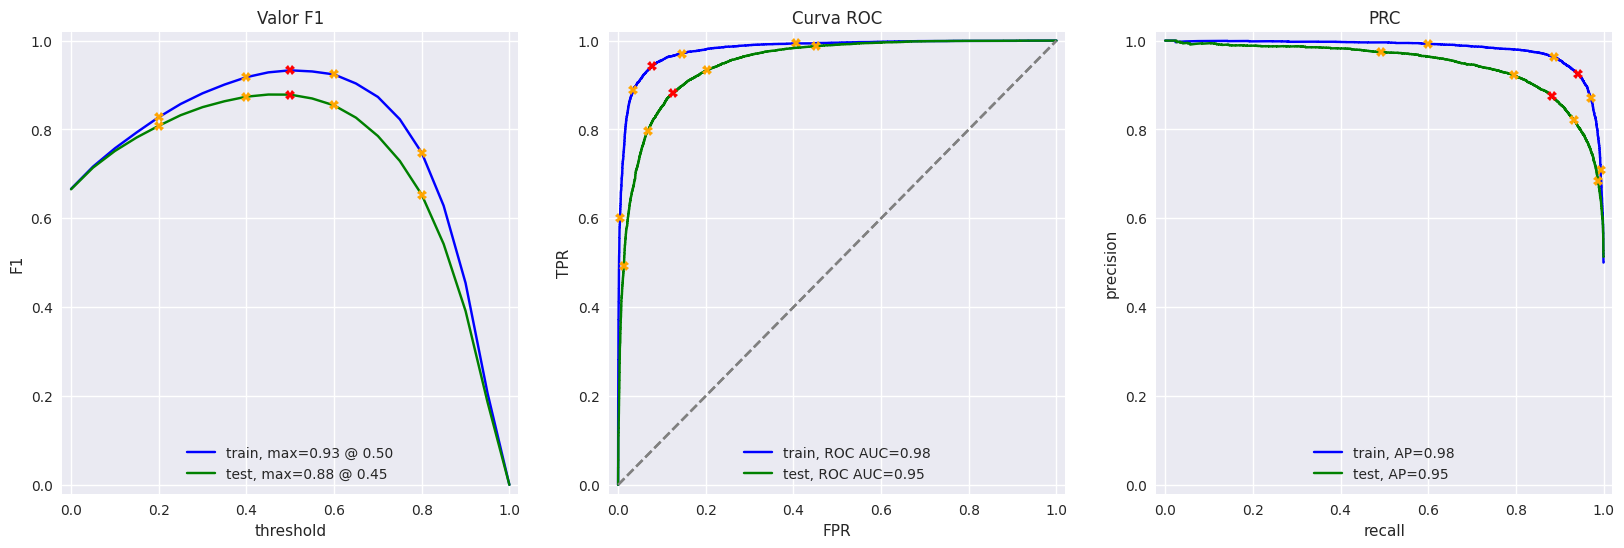

In [46]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

En este modelo creamos una función utilizando spaCy para la lemantización de texto, posteriormente aplicamos TF-IDF como vectorizador para obterner las caracteristicas y entrenamos el modelo de regresión logistica de la misma forma que en el modelo 1. 

Como resultados obtuvimos practicamente los mismo que en el modelo 1: F1 de 0.88, ROC 0.95 y APS de 0.95.
Podemos decir que para este conjunto de datos, la lemantización no aporto cambios significativos y con la limpieza básica y vectorización con TF-IDF son suficientes para lograr un rendimiento óptimo. 

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [47]:
from lightgbm import LGBMClassifier

In [48]:
#Entrenamiento de modelo
model_4 = LGBMClassifier()
model_4.fit(train_features_3,train_target)

LGBMClassifier()

           train  test
Exactitud    NaN   NaN
F1          0.92  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


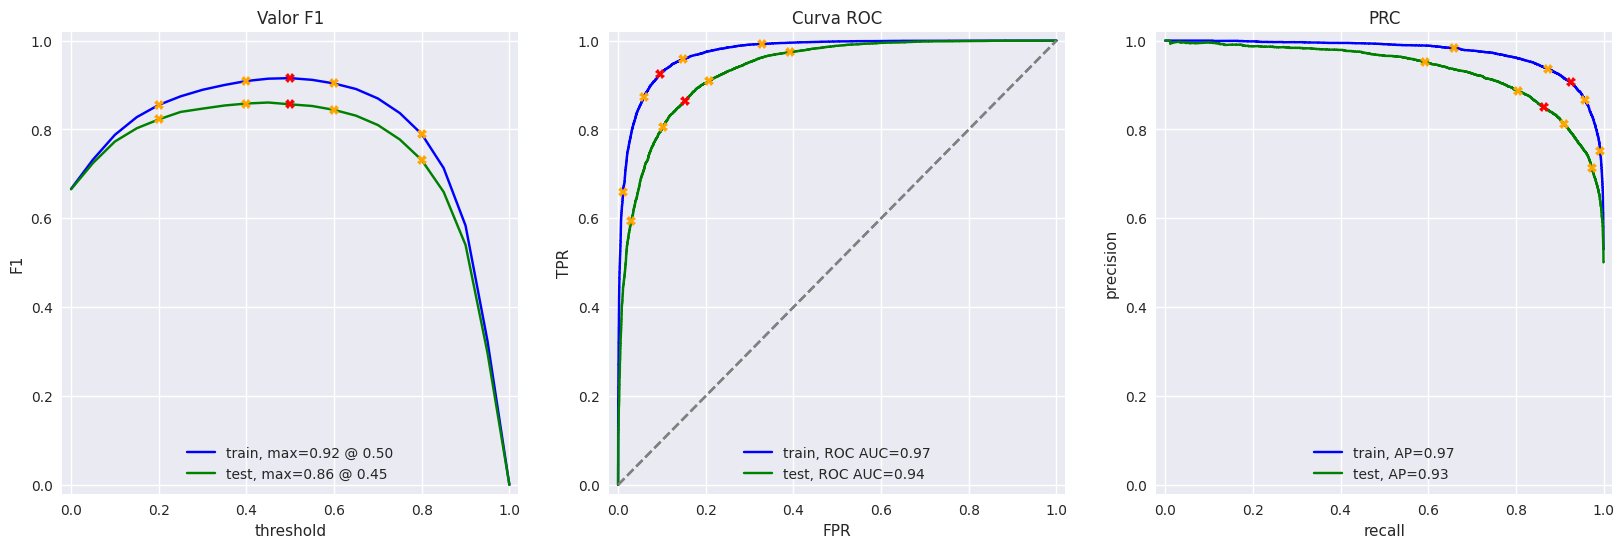

In [49]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

En el Modelo 4 se reutilizó el preprocesamiento basado en spaCy y TF-IDF, pero se reemplazó la regresión logística por un clasificador basado en LightGBM (LGBMClassifier).

A pesar de tratarse de un modelo más complejo, el rendimiento fue ligeramente inferior al de los modelos anteriores. Se obtuvo un F1 de 0.86, ROC AUC de 0.94, y APS de 0.93 en el conjunto de prueba. Esto sugiere que, en este caso, la complejidad adicional no aportó mejoras significativas y que la regresión logística con TF-IDF ya era suficiente.

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [50]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [52]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [54]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn t expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.30:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

Hemos aplicado los 3 modelos a my_reviews, tome una muestra de una reseña claramente positiva y otra negativa y podemos observar lo siguiente:

Negativa
Model_1 NLKT, TF-IDF y LR.
0.14:  i did not simply like it not my kind of movie

Model_3 spaCy, TF-IDF y LR. 
0.21:  i did not simply like it not my kind of movie

Model_4 spaCy, TF-IDF y LGBMClassifier
0.59:  i did not simply like it not my kind of movie

El modelo 1 y 3 identificaron correctamente el tono negativo, asignando probabilidades bajas de positividad (0.14 y 0.21, respectivamente), mientras que el modelo 4 basado en LGBMClassifier, asignó una probabilidad mucho más alta (0.59), lo cual sugiere que este modelo podría estar más influenciado por palabras individuales y menos por el contexto completo, mostrando cierta debilidad en ejemplos sutiles o ambivalentes.

Positivas
Model_1 NLKT, TF-IDF y LR.
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo

Model_3 spaCy, TF-IDF y LR. 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo

Model_4 spaCy, TF-IDF y LGBMClassifier
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo

Los tres modelos pueden predecir de forma correcta que se trata de una reseña positiva, confirmando que el modelo LGBM considera palabras individuales y no tanto el contexto.

Se entrenaron varios modelos de clasificación para detectar si una reseña de película es positiva o negativa usando datos de IMDB.
Se aplicaron técnicas de preprocesamiento textual, vectorización con TF-IDF y modelos como regresión logística y LightGBM.

El modelo con mejor rendimiento fue el basado en TF-IDF y regresión logística, con un F1-score de 0.88 en el conjunto de prueba. También se evaluaron reseñas nuevas, donde los modelos mostraron buen comportamiento general.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 